In [ ]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.3MB 1.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report,confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Processing**

In [ ]:
filesPath001="/content/drive/My Drive/Datasets/PS_20174392719_1491204439457_log.csv"
finInfo = pd.read_csv(filesPath001)
finInfo.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
finInfo.isnull().values.any()
print(finInfo.dtypes)

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [ ]:
encoder = LabelEncoder()
typeTransaction = finInfo['type']
nameO = finInfo['nameOrig']
nameD = finInfo['nameDest']
#finInfo.drop(columns='step', inplace=True)
finInfo['nameOrig'] = encoder.fit_transform(nameO)
finInfo['nameDest'] = encoder.fit_transform(nameD)
finInfo['type'] = encoder.fit_transform(typeTransaction)
finInfo.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


amount            0.076688
isFlaggedFraud    0.044109
type              0.020833
oldbalanceOrg     0.010154
newbalanceDest    0.000535
nameOrig         -0.000464
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
nameDest         -0.021963
Name: isFraud, dtype: float64

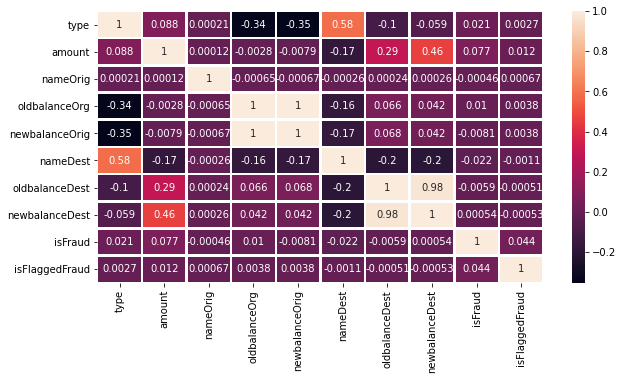

In [ ]:

Correlation = finInfo.corr()
plt.figure(figsize=(10,5))
sns.heatmap(Correlation, xticklabels=Correlation.columns, yticklabels=Correlation.columns, annot=True, linewidth = 1.5)
Correlation.sort_values(by=["isFraud"],ascending=False,inplace=True)
Correlation["isFraud"][1:]

**KNN with all features**

0.9990532202143142
ROC_AUC_SCORE: 0.9410607040039879


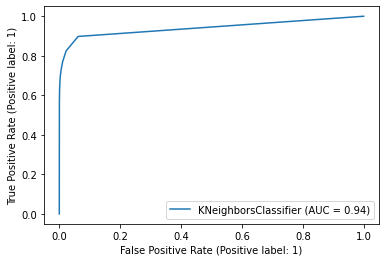

In [ ]:
#500 neighbors because 2270 is supposed to be optimal but 1000-2270 crashes runtime by using up all the ram
y = finInfo['isFraud']
X = finInfo.drop(columns=['isFraud'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
knn = KNeighborsClassifier(n_neighbors=300)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print(accuracy_score(y_test, y_pred))
y_pred_prob = knn.predict_proba(X_test)
print("ROC_AUC_SCORE:",roc_auc_score(y_test,y_pred_prob[:,1]))
metrics.plot_roc_curve(knn, X_test, y_test)

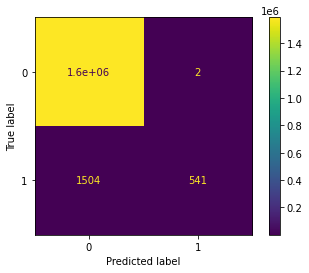

In [ ]:
plot_confusion_matrix(knn, X_test, y_test) 

**KNN with features selected**

In [ ]:
y = finInfo['isFraud']
X = finInfo.drop(['isFraud','newbalanceDest','nameOrig','oldbalanceDest','newbalanceOrig'], axis = 1)
X.head()

,step,type,amount,oldbalanceOrg,nameDest,isFlaggedFraud
0,1,3,9839.64,170136.0,1662094,0
1,1,3,1864.28,21249.0,1733924,0
2,1,4,181.00,181.0,439685,0
3,1,1,181.00,181.0,391696,0
4,1,3,11668.14,41554.0,828919,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
#300 neighbors because 2270 is supposed to be optimal but 500-2270 crashes runtime by using up all the ram
knnFeatureExtract = KNeighborsClassifier(n_neighbors=8)
knnFeatureExtract.fit(X_train,y_train)
y_pred = knnFeatureExtract.predict(X_test)

Accuracy: 0.9992160462199534
ROC_AUC_SCORE: 0.9067959340260078


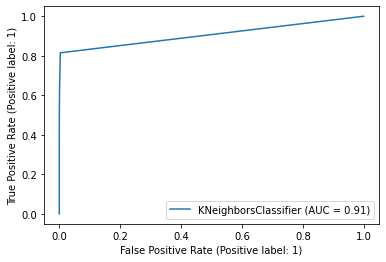

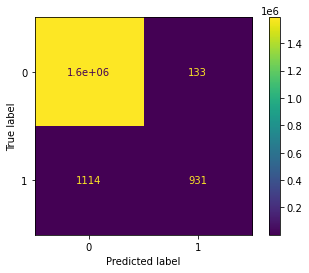

In [ ]:
y_pred_prob = knnFeatureExtract.predict_proba(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC_AUC_SCORE:",roc_auc_score(y_test,y_pred_prob[:,1]))
metrics.plot_roc_curve(knnFeatureExtract, X_test, y_test)
plot_confusion_matrix(knnFeatureExtract, X_test, y_test) 

Accuracy: 0.9991374622403978
ROC_AUC_SCORE: 0.9902507081701062


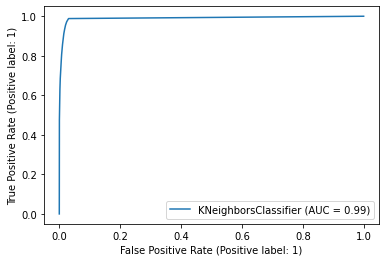

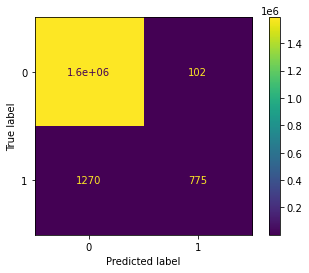

In [ ]:
knnFeatureExtract = KNeighborsClassifier(n_neighbors=300)
knnFeatureExtract.fit(X_train,y_train)
y_pred = knnFeatureExtract.predict(X_test)
y_pred_prob = knnFeatureExtract.predict_proba(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC_AUC_SCORE:",roc_auc_score(y_test,y_pred_prob[:,1]))
metrics.plot_roc_curve(knnFeatureExtract, X_test, y_test)
plot_confusion_matrix(knnFeatureExtract, X_test, y_test) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
print('Feature  Accuracy - type')
labels = ['type', 'amount', 'oldbalanceOrg', 'nameDest', 'isFlaggedFraud']
knnFeatureExtract = KNeighborsClassifier(n_neighbors=8)
X1 = X_train.drop(['amount','oldbalanceOrg','nameDest', 'isFlaggedFraud'], axis = 1)
cv_scores = cross_val_score(knnFeatureExtract, X1, y_train, cv=3, scoring = 'accuracy')
average = cv_scores.mean()
print("Feature - type and the score average is " +str(average))

Feature  Accuracy - type
Feature - type and the score average is 0.9989485463646606


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
print('Feature  Accuracy - amount')
labels = ['type', 'amount', 'oldbalanceOrg', 'nameDest', 'isFlaggedFraud']
knnFeatureExtract = KNeighborsClassifier(n_neighbors=8)
X1 = X_train.drop(['type','oldbalanceOrg','nameDest', 'isFlaggedFraud'], axis = 1)
cv_scores = cross_val_score(knnFeatureExtract, X1, y_train, cv=3, scoring = 'accuracy')
average = cv_scores.mean()
print("Feature - type and the score average is " +str(average))

Feature  Accuracy - amount
Feature - type and the score average is 0.9987638740022066


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
print('Feature  Accuracy - oldbalanceOrg')
labels = ['type', 'amount', 'oldbalanceOrg', 'nameDest', 'isFlaggedFraud']
knnFeatureExtract = KNeighborsClassifier(n_neighbors=8)
X1 = X_train.drop(['type','amount','nameDest', 'isFlaggedFraud'], axis = 1)
cv_scores = cross_val_score(knnFeatureExtract, X1, y_train, cv=3, scoring = 'accuracy')
average = cv_scores.mean()
print("Feature - type and the score average is " +str(average))

Feature  Accuracy - oldbalanceOrg
Feature - type and the score average is 0.998760730632526


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
print('Feature  Accuracy - nameDest')
labels = ['type', 'amount', 'oldbalanceOrg', 'nameDest', 'isFlaggedFraud']
knnFeatureExtract = KNeighborsClassifier(n_neighbors=8)
X1 = X_train.drop(['type','amount','oldbalanceOrg', 'isFlaggedFraud'], axis = 1)
cv_scores = cross_val_score(knnFeatureExtract, X1, y_train, cv=3, scoring = 'accuracy')
average = cv_scores.mean()
print("Feature - type and the score average is " +str(average))

Feature  Accuracy - nameDest
Feature - type and the score average is 0.9987402988083399


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
print('Feature  Accuracy - isFlaggedFraud')
labels = ['type', 'amount', 'oldbalanceOrg', 'nameDest', 'isFlaggedFraud']
knnFeatureExtract = KNeighborsClassifier(n_neighbors=8)
X1 = X_train.drop(['type','amount','oldbalanceOrg', 'nameDest'], axis = 1)
cv_scores = cross_val_score(knnFeatureExtract, X1, y_train, cv=3, scoring = 'accuracy')
average = cv_scores.mean()
print("Feature - type and the score average is " +str(average))

Feature  Accuracy - isFlaggedFraud
Feature - type and the score average is 0.9990326312215503


In [ ]:
k_range = list(range(1,50))
accuraciesMinMax = []
for k in k_range:
    if k%2 != 0:
        knnFeatureExtract = KNeighborsClassifier(n_neighbors = k)
        cv_scores = cross_val_score(knnFeatureExtract, X_train, y_train, cv=3, scoring = 'accuracy')
        average = cv_scores.mean()
        accuraciesMinMax.append(average)
        print("K value = " + str(k) + " and the score average is " +str(average))


K value = 1 and the score average is 0.9990324740437115
K value = 3 and the score average is 0.9992648730659174
K value = 5 and the score average is 0.9992613105921775
K value = 7 and the score average is 0.999237001947835
K value = 9 and the score average is 0.9992034727832245
K value = 11 and the score average is 0.999173506092354
K value = 13 and the score average is 0.9991489878907327
K value = 15 and the score average is 0.9991244696891113
K value = 17 and the score average is 0.9991064477631332
K value = 19 and the score average is 0.9990825582333484
K value = 21 and the score average is 0.9990664223228795
K value = 23 and the score average is 0.9990555253443811
K value = 25 and the score average is 0.9990391798766337
K value = 27 and the score average is 0.999025139538953
K value = 29 and the score average is 0.99901151831583
K value = 31 and the score average is 0.9990041838110715
K value = 33 and the score average is 0.9989951728480825
K value = 35 and the score average is 0.9

Best k value is 2 with accuracy 0.9992648730659174


Text(0.5, 1.0, 'Accuracy vs k')

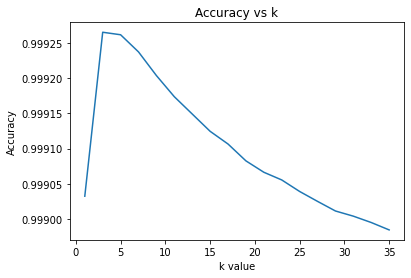

In [ ]:
import math
accuraciesMinMax = [0.9990324740437115, 0.9992648730659174, 0.9992613105921775, 0.999237001947835, 0.9992034727832245,0.999173506092354, 0.9991489878907327,0.9991244696891113, 
                   0.9991064477631332, 0.9990825582333484, 0.9990664223228795, 0.9990555253443811, 0.9990391798766337, 0.999025139538953, 0.99901151831583,0.9990041838110715,
                   0.9989951728480825, 0.9989846949841418]
k_range = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35]
maxAccuracy = max(accuraciesMinMax)
indexOfMax = accuraciesMinMax.index(maxAccuracy)
k_value = indexOfMax + 1
print("Best k value is " + str(k_value) + " with accuracy " + str(maxAccuracy) )
plt.plot(k_range,accuraciesMinMax)
plt.xlabel("k value")
plt.ylabel("Accuracy")
plt.title("Accuracy vs k")